# Retrospective hotspotting

Recall that the "retrospective hotspot" method has no sense of time (but _often_ a sliding window of time is used, e.g. the last 8 weeks of data before the prediction date) and is a (normally grid based) KDE method.

In [1]:
%matplotlib inline
from common import *
datadir = os.path.join("//media", "disk", "Data")
#datadir = os.path.join("..", "..", "..", "..", "..", "Data")

GDAL_DATA not set and failed to find suitable location...  This is probably not a problem on linux.


In [2]:
south_side, points = load_data(datadir)

# Find the masked grid to use

It is definitely worth exploring how changing the offset of the grid affects prediction...

In [3]:
masked_grid = grid_for_south_side()
print("Total number of cells in region:", masked_grid.xextent * masked_grid.yextent)
print("Number of cells which intersect geometry:", np.sum(~masked_grid.mask))

Total number of cells in region: 2058
Number of cells which intersect geometry: 961


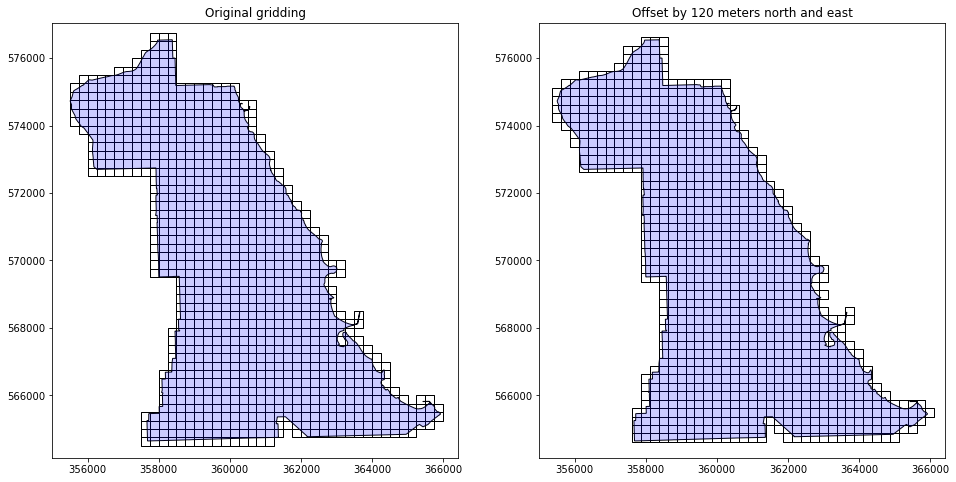

In [4]:
fig, ax  = plt.subplots(ncols=2, figsize=(16,8))

for a in ax:
    a.add_patch(descartes.PolygonPatch(south_side, fc="none", ec="Black"))
    a.add_patch(descartes.PolygonPatch(south_side, fc="Blue", ec="none", alpha=0.2))
    xmin, ymin, xmax, ymax = south_side.bounds
    a.set(xlim=[xmin-500,xmax+500], ylim=[ymin-500,ymax+500])

pc = open_cp.plot.patches_from_grid(grid_for_south_side())
ax[0].add_collection(matplotlib.collections.PatchCollection(pc, facecolor="None", edgecolor="black"))
pc = open_cp.plot.patches_from_grid(grid_for_south_side(xoffset=120, yoffset=120))
ax[1].add_collection(matplotlib.collections.PatchCollection(pc, facecolor="None", edgecolor="black"))
ax[0].set_title("Original gridding")
ax[1].set_title("Offset by 120 meters north and east")
None

# Comparison between grid based and continuous

In [5]:
cts_pred = retro.RetroHotSpot()
cts_pred.data = points
cts_pred.weight = retro.Quartic(bandwidth = 1000)
cts_risk = cts_pred.predict(end_time = np.datetime64("2011-09-28"))
cts_grid_risk = open_cp.predictors.grid_prediction(cts_risk, masked_grid)

grid_pred = retro.RetroHotSpotGrid(grid=masked_grid)
grid_pred.data = points
grid_pred.weight = retro.Quartic(bandwidth = 1000)
grid_risk = grid_pred.predict(end_time = np.datetime64("2011-09-28"))
grid_risk.mask_with(masked_grid)

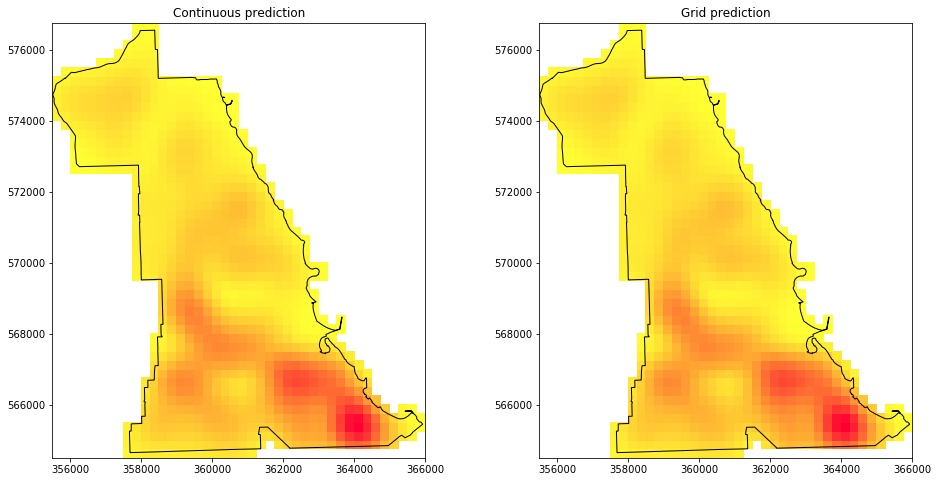

In [6]:
fig, ax  = plt.subplots(ncols=2, figsize=(16,8))

for a in ax:
    a.set_aspect(1)
    a.add_patch(descartes.PolygonPatch(south_side, fc="none", ec="Black"))
    
ax[0].pcolormesh(*cts_grid_risk.mesh_data(), cts_grid_risk.intensity_matrix, cmap=yellow_to_red)
ax[0].set_title("Continuous prediction")
ax[1].pcolormesh(*grid_risk.mesh_data(), grid_risk.intensity_matrix, cmap=yellow_to_red)
ax[1].set_title("Grid prediction")
None

# Baseline hit rate

In [8]:
evaluator = open_cp.evaluation.HitRateEvaluator(RetroHotSpotEval(masked_grid, points))
evaluator.data = points
result = evaluator.run(time_range(), range(0,51))

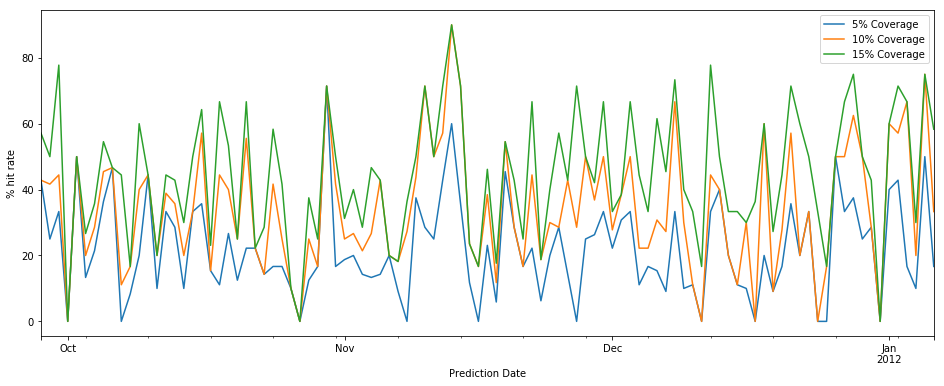

In [9]:
frame = to_dataframe(result.rates)

fig, ax = plt.subplots(figsize=(16,6))
(frame[5] * 100).plot(ax=ax)
(frame[10] * 100).plot(ax=ax)
(frame[15] * 100).plot(ax=ax)
ax.set_ylabel("% hit rate")
ax.legend(["{}% Coverage".format(x) for x in [5,10,15]])
None

In [10]:
frame.describe()

% Coverage,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
count,101.0,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,...,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,0.0,0.058428,0.094211,0.143468,0.182115,0.219540,0.250367,0.275972,0.296387,0.318754,...,0.786373,0.800066,0.810977,0.819463,0.823896,0.833025,0.841410,0.846518,0.847343,0.858134
std,0.0,0.091692,0.104734,0.127985,0.146259,0.146781,0.153076,0.167002,0.168620,0.178851,...,0.155703,0.146743,0.144682,0.141394,0.137113,0.136176,0.138409,0.136089,0.136261,0.127632
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.250000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000
25%,0.0,0.000000,0.000000,0.000000,0.083333,0.111111,0.142857,0.166667,0.187500,0.200000,...,0.714286,0.714286,0.727273,0.750000,0.750000,0.769231,0.777778,0.777778,0.777778,0.800000
50%,0.0,0.000000,0.076923,0.125000,0.166667,0.200000,0.230769,0.263158,0.285714,0.300000,...,0.800000,0.823529,0.833333,0.833333,0.833333,0.857143,0.857143,0.857143,0.857143,0.857143
75%,0.0,0.111111,0.166667,0.222222,0.285714,0.333333,0.333333,0.375000,0.416667,0.444444,...,0.888889,0.888889,0.909091,0.909091,0.916667,0.923077,0.941176,1.000000,1.000000,1.000000
max,0.0,0.400000,0.400000,0.500000,0.500000,0.714286,0.800000,0.900000,0.900000,0.900000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


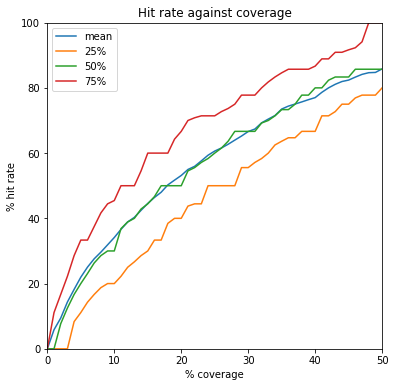

In [11]:
fig, ax = plt.subplots(figsize=(6,6))

d = frame.describe()
ax.plot(d.columns, d.ix["mean"]*100)
ax.plot(d.columns, d.ix["25%"]*100)
ax.plot(d.columns, d.ix["50%"]*100)
ax.plot(d.columns, d.ix["75%"]*100)
ax.legend()
ax.set(ylabel="% hit rate", xlabel="% coverage")
ax.set_title("Hit rate against coverage")
ax.set(xlim=[0,50], ylim=[0,100])
None

# Show how the prediction changes over time

In [12]:
predictions = []
times = list(result.details)
times.sort()
for time in times:
    predictions.append( result.details[time].prediction )

In [ ]:
from matplotlib import animation
matplotlib.rc('animation', html='html5')

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect(1)
ax.add_patch(descartes.PolygonPatch(south_side, fc="none", ec="Black"))

In [ ]:
def animator(n):
    pred = predictions[n]
    ax.collections = []
    mesh = ax.pcolormesh(*pred.mesh_data(), pred.intensity_matrix, cmap=yellow_to_red)
    ax.set_title("Risk density on {}".format(times[n]))
    return mesh

In [ ]:
animation.FuncAnimation(fig, animator, frames=len(predictions), interval=100, blit=False)

# Effect of varying the grid

We'll look at how varying the offset of the grid changes the hit rate.
- To avoid visualising massive amounts of data, we'll look at 5% coverage only

In [7]:
# This takes a long time to run..
with open_cp.pool.PoolExecutor() as executor:
    futures = []
    for xoffset in range(0, 250, 5):
        for yoffset in range(0, 250, 5):
            masked_grid = grid_for_south_side(xoffset, yoffset)
            task = RHS_Eval_Task(masked_grid, points, (xoffset, yoffset))
            futures.append( executor.submit(task) )
            
    grid_effect = {}
    for key, result in open_cp.pool.yield_task_results(futures):
        grid_effect[key] = result.rates

In [16]:
import pickle, lzma
with lzma.open(os.path.join("grid.pic.xz"), "wb") as f:
    pickle.dump(grid_effect, f)

## Here's one we prepared earlier

In [20]:
import pickle, lzma
with lzma.open(os.path.join("grid.pic.xz"), "rb") as f:
    grid_effect = pickle.load(f)

In [21]:
def to_mean(result):
    frame = to_dataframe(result)
    return frame.describe()[5]["mean"]

means = { key : to_mean(value) for key, value in grid_effect.items() }

In [23]:
first_axis_keys = set(k[0] for k in means.keys())
second_axis_keys = set(k[1] for k in means.keys())
frame = pd.DataFrame({k:{l:means[(k,l)] for l in second_axis_keys} for k in first_axis_keys})
frame

,0,5,10,15,20,25,30,35,40,45,...,200,205,210,215,220,225,230,235,240,245
0,0.219540,0.221362,0.224662,0.219466,0.225994,0.223444,0.226008,0.224680,0.223073,0.219714,...,0.220867,0.219767,0.221518,0.223251,0.222351,0.223251,0.224241,0.221883,0.221718,0.220618
5,0.222290,0.224112,0.220291,0.223912,0.225287,0.223637,0.226201,0.224963,0.221144,0.219006,...,0.221574,0.219767,0.220289,0.223437,0.223437,0.223133,0.222708,0.221058,0.221011,0.221011
10,0.222670,0.221192,0.221742,0.220917,0.221742,0.225186,0.227131,0.224903,0.220974,0.219544,...,0.222504,0.221110,0.221220,0.222603,0.222917,0.221577,0.222381,0.219741,0.221391,0.222835
15,0.222038,0.223035,0.219310,0.224204,0.226129,0.226129,0.228074,0.223477,0.224891,0.219151,...,0.220485,0.219091,0.219908,0.221181,0.220528,0.219503,0.219503,0.219859,0.219859,0.222203
20,0.221213,0.224404,0.220410,0.225811,0.226054,0.226467,0.226954,0.225599,0.226149,0.222236,...,0.215916,0.216026,0.216843,0.220288,0.221049,0.220024,0.220849,0.219034,0.222203,0.223028
25,0.222863,0.224986,0.226637,0.225811,0.227049,0.226342,0.227537,0.227006,0.226731,0.224134,...,0.214356,0.217694,0.216940,0.218397,0.218409,0.220224,0.219949,0.222293,0.222128,0.222953
30,0.220478,0.222205,0.223855,0.223030,0.223167,0.224032,0.227584,0.224916,0.225741,0.224134,...,0.217860,0.214960,0.214830,0.215537,0.216299,0.220224,0.222533,0.221633,0.220643,0.220643
35,0.217490,0.220719,0.223195,0.222782,0.222507,0.222979,0.226484,0.224421,0.223431,0.220586,...,0.215364,0.214311,0.214091,0.213227,0.218174,0.218793,0.220993,0.220093,0.218993,0.218993
40,0.217717,0.219132,0.220782,0.219682,0.220507,0.221921,0.222951,0.222421,0.221431,0.218998,...,0.213743,0.212504,0.212991,0.214752,0.216132,0.217261,0.217812,0.216911,0.219083,0.217374
45,0.215566,0.216981,0.216431,0.216431,0.217256,0.218670,0.219700,0.219788,0.218963,0.216366,...,0.212643,0.209186,0.210003,0.213500,0.212979,0.212979,0.213199,0.213669,0.214081,0.214906


In [30]:
data = np.asarray([np.asarray(frame[x]) for x in frame.columns])
data.shape

(50, 50)

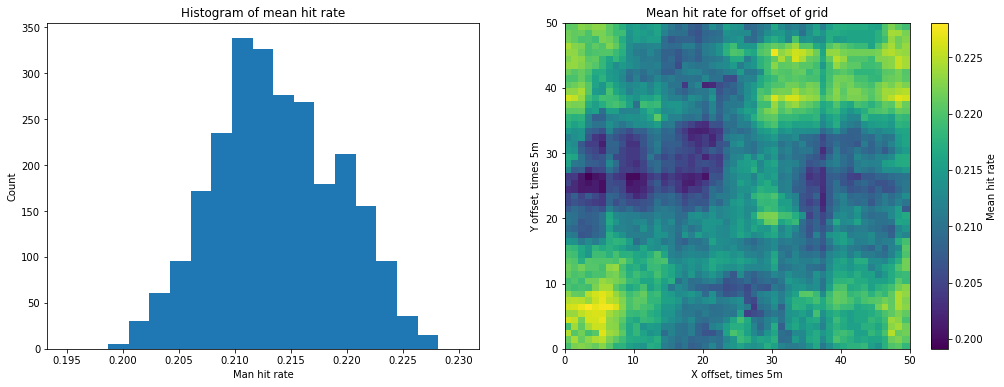

In [43]:
fig, axes = plt.subplots(ncols=2, figsize=(17,6))

ax = axes[0]
ax.hist(data.flatten(), bins=np.linspace(0.195, 0.23, 20))
ax.set_title("Histogram of mean hit rate")
ax.set_xlabel("Man hit rate")
ax.set_ylabel("Count")

ax = axes[1]
mappable = ax.pcolor(data)
ax.set_title("Mean hit rate for offset of grid")
ax.set_xlabel("X offset, times 5m")
ax.set_ylabel("Y offset, times 5m")
cbar = plt.colorbar(mappable)
cbar.set_label("Mean hit rate")
None